In [78]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from feature_engine.outliers import Winsorizer
from sklearn.impute import SimpleImputer
import scipy.stats as stats
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [82]:
# reading the data from the file 
claim_data = pd.read_csv("C:\\Users\\Harin\\Downloads\\insurance_fraud_claim\\Data Set.csv")

In [84]:
#data set information
claim_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5250 entries, 0 to 5249
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Claim_ID           5250 non-null   object 
 1   Claimant_Name      5250 non-null   object 
 2   Claimant_Address   5250 non-null   object 
 3   Insurance_Type     5250 non-null   object 
 4   Fraud_Category     4013 non-null   object 
 5   Claim_Amount       5250 non-null   float64
 6   Claim_Date         5250 non-null   object 
 7   Claim_Status       5250 non-null   object 
 8   Fraud_Flag         5250 non-null   int64  
 9   Claim_Description  5250 non-null   object 
 10  Missing_Field      0 non-null      float64
dtypes: float64(2), int64(1), object(8)
memory usage: 451.3+ KB


In [85]:
# Convert Claim_Date to datetime @ the Claim_Date data type was object. We can perform the statistics on datetime
claim_data['Claim_Date'] = pd.to_datetime(claim_data['Claim_Date'])

In [86]:
#dropping the columns
claim_data.drop(columns = ['Claim_Description','Missing_Field','Claim_ID'],inplace = True)

In [89]:
#View the sample data 
claim_data.sample(10)

,Claimant_Name,Claimant_Address,Insurance_Type,Fraud_Category,Claim_Amount,Claim_Date,Claim_Status,Fraud_Flag
2024,Sarah Fletcher,"948 Melissa Lodge, Port Timothy, MI 97533",Vehicle,Staged Accident,16804.84,2020-10-25,Denied,1
4061,Joshua Howard,"3864 Justin Points, North Nicholasberg, MI 92530",Vehicle,Exaggerated Loss,16484.88,2020-04-20,Denied,1
3499,Charles Drake,"53106 Salinas Isle, East Peter, OH 30727",General,None,28354.14,2021-05-25,Denied,0
3288,Shannon Navarro,"072 Vega Hill Apt. 472, Lake Kimberly, OR 83669",Life,Exaggerated Loss,1601.73,2020-12-01,Denied,1
3566,Denise Lee,"718 Patterson Greens Apt. 369, Theresamouth, N...",Vehicle,Intentional Damage,16882.61,2024-07-05,Under Review,1
1450,Kelly Johnson,"8485 Reynolds Isle, South Carmenfurt, VT 07247",General,Exaggerated Loss,21224.34,2024-03-08,Approved,1
2955,Gina Wolf,"899 Katherine Wall, Burnsfurt, IN 91778",Vehicle,None,15230.93,2021-06-23,Denied,0
3235,Gabriel Robbins,"53016 Norman Crest Suite 417, New Christine, N...",Health,Exaggerated Loss,10254.88,2020-11-26,Denied,1
2631,Randall Anderson,"773 Stone Valleys Apt. 750, East Sarah, FL 30853",General,Staged Accident,1394.21,2022-03-14,Denied,1
1497,William Goodman,"9539 Cook Island, Curtisbury, AR 17283",Health,Exaggerated Loss,11704.50,2024-12-23,Under Review,1


In [88]:
#The Fraud_category NONE is treated as a NAN  , we can handle explicitly to replace the NAN with NONE 
claim_data["Fraud_Category"] = claim_data["Fraud_Category"].fillna("None")


In [91]:
# find the count of total records  and unique values the records of data 
pd.DataFrame({'count': claim_data.notnull().sum(),
              'unique': claim_data.nunique()})

,count,unique
Claimant_Name,5250,4833
Claimant_Address,5250,5000
Insurance_Type,5250,4
Fraud_Category,5250,4
Claim_Amount,5250,4996
Claim_Date,5250,1753
Claim_Status,5250,3
Fraud_Flag,5250,2


In [51]:
#summary statistics
claim_data.Claim_Amount.describe().T

count     5250.000000
mean     12812.897890
std       8656.431191
min        280.940000
25%       5769.092500
50%      11066.875000
75%      18420.750000
max      39360.070000
Name: Claim_Amount, dtype: float64

In [92]:
# Extract Year and Month for grouping
claim_data['State'] = claim_data['Claimant_Address'].str.extract(r',\s([A-Z]{2})\s\d{5}')
claim_data['Year'] = claim_data['Claim_Date'].dt.year
claim_data['Month'] = claim_data['Claim_Date'].dt.month
claim_data = claim_data.drop(columns=['Claimant_Address'])

In [93]:
claim_data.sample(10)

,Claimant_Name,Insurance_Type,Fraud_Category,Claim_Amount,Claim_Date,Claim_Status,Fraud_Flag,State,Year,Month
2074,Mr. Dale Barron,Life,Intentional Damage,29385.92,2021-12-28,Denied,1,ND,2021,12
3732,Andrea Parker,Health,Intentional Damage,3858.01,2020-03-24,Under Review,1,GA,2020,3
738,Julie Gill,General,Staged Accident,22420.31,2022-05-08,Approved,1,MT,2022,5
4611,Nicholas Bryant,General,Exaggerated Loss,14717.12,2022-08-10,Denied,1,NaN,2022,8
81,Rhonda Mayer,Health,Exaggerated Loss,5590.21,2020-07-16,Under Review,1,DE,2020,7
2563,Holly Pennington,Life,Exaggerated Loss,32932.51,2024-07-26,Denied,1,TX,2024,7
2126,Heather Jimenez,Vehicle,Exaggerated Loss,18156.53,2022-07-29,Denied,1,MA,2022,7
5004,Christine Smith,Health,None,15078.71,2021-08-26,Under Review,0,ND,2021,8
3151,Darryl Austin,Vehicle,Intentional Damage,27523.38,2023-09-02,Under Review,1,AK,2023,9
3617,Diana Smith,Vehicle,None,5480.78,2021-10-12,Approved,0,KS,2021,10


In [95]:
# Summary statistics for Claim_Amount by Insurance_Type and Fraud_Category
summary_stats = claim_data.groupby(['Insurance_Type', 'Fraud_Category','Claim_Status'])['Claim_Amount'].describe()

# Define column headers
headers = ['Insurance_Type', 'Fraud_Category','Claim_Status'] + list(summary_stats.columns)

# Create a formatted table
print("\nSummary Statistics for Claim Amount by Insurance Type and Fraud Category and claim status:")
print("-" * 130)  # Adjusted table border width
print(f"{headers[0]:<15} {headers[1]:<20} {headers[2]:>8} {headers[3]:>8} {headers[4]:>8} {headers[5]:>8} {headers[6]:>8} {headers[7]:>8} {headers[8]:>8} {headers[9]:>8}")
print("-" * 130)

# Print each row
for (insurance_type, fraud_category,Claim_Status), row in summary_stats.iterrows():
    print(f"{insurance_type:<15} {fraud_category:<20} {Claim_Status:<20} {row['count']:>8.0f} {row['mean']:>8.2f} {row['std']:>8.2f} {row['min']:>8.2f} {row['25%']:>8.2f} {row['50%']:>8.2f} {row['75%']:>8.2f} {row['max']:>8.2f}")
print("-" * 130)


Summary Statistics for Claim Amount by Insurance Type and Fraud Category and claim status:
----------------------------------------------------------------------------------------------------------------------------------
Insurance_Type  Fraud_Category       Claim_Status    count     mean      std      min      25%      50%      75%
----------------------------------------------------------------------------------------------------------------------------------
General         Exaggerated Loss     Approved                  133 12249.63  8694.76   633.22  5552.54 10251.81 18270.23 36929.36
General         Exaggerated Loss     Denied                    119 12188.23  9008.77   441.88  4928.45  9931.00 17930.97 34685.66
General         Exaggerated Loss     Under Review              110 12344.20  8343.17   595.27  5420.12 11018.65 18353.68 33548.66
General         Intentional Damage   Approved                  109 11203.19  8146.75   702.26  4564.54  9393.53 16890.47 33998.92
General      

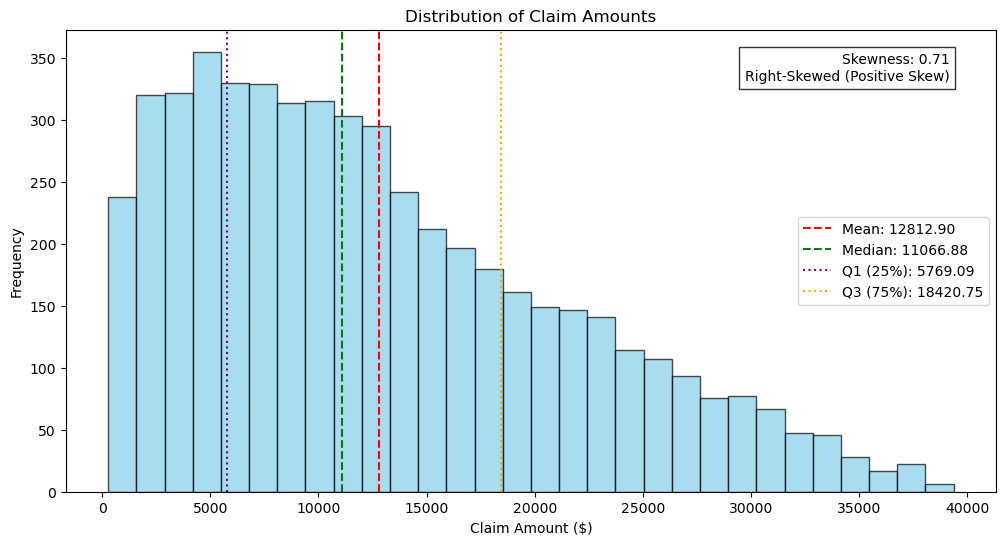


Explanation of the Histogram and Skewness:
1. Skewness Value: 0.71
   - Positive (> 0): Right-skewed (tail on the right, more small claims).
   - Negative (< 0): Left-skewed (tail on the left, more large claims).
   - Near 0: Symmetric (balanced distribution).
2. Mean (12812.90) vs. Median (11066.88):
   - If Mean > Median: Suggests right skew (common in claim data).
   - If Mean < Median: Suggests left skew.
3. Quartiles (Q1 = 5769.09, Q3 = 18420.75):
   - Show the spread of the middle 50% of claims.
   - Wide gap between Q1 and Q3 indicates high variability.


In [96]:
#skweness performed on the clean data set
# Calculate skewness on the claim_amount

skewness = stats.skew(claim_data['Claim_Amount'].dropna())  
mean_val = claim_data['Claim_Amount'].mean()
median_val = claim_data['Claim_Amount'].median()
q1 = claim_data['Claim_Amount'].quantile(0.25)
q3 = claim_data['Claim_Amount'].quantile(0.75)

# Create the histogram
plt.figure(figsize=(12, 6))
n, bins, patches = plt.hist(claim_data['Claim_Amount'], bins=30, edgecolor='black', color='skyblue', alpha=0.7)
plt.title('Distribution of Claim Amounts')
plt.xlabel('Claim Amount ($)')
plt.ylabel('Frequency')
#plt.grid(True, alpha=0.3)

# Add vertical lines for mean, median, and quartiles
plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.2f}')
plt.axvline(q1, color='purple', linestyle=':', label=f'Q1 (25%): {q1:.2f}')
plt.axvline(q3, color='orange', linestyle=':', label=f'Q3 (75%): {q3:.2f}')

# Add skewness annotation
skew_text = f'Skewness: {skewness:.2f}\n'
if skewness > 0:
    skew_text += 'Right-Skewed (Positive Skew)'
elif skewness < 0:
    skew_text += 'Left-Skewed (Negative Skew)'
else:
    skew_text += 'Approximately Symmetric'
plt.text(0.95, 0.95, skew_text, transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top', horizontalalignment='right', 
         bbox=dict(facecolor='white', alpha=0.8))

# Add legend
plt.legend()

# Show the plot
plt.show()

# Print summary
print("\nExplanation of the Histogram and Skewness:")
print(f"1. Skewness Value: {skewness:.2f}")
print("   - Positive (> 0): Right-skewed (tail on the right, more small claims).")
print("   - Negative (< 0): Left-skewed (tail on the left, more large claims).")
print("   - Near 0: Symmetric (balanced distribution).")
print(f"2. Mean ({mean_val:.2f}) vs. Median ({median_val:.2f}):")
print("   - If Mean > Median: Suggests right skew (common in claim data).")
print("   - If Mean < Median: Suggests left skew.")
print(f"3. Quartiles (Q1 = {q1:.2f}, Q3 = {q3:.2f}):")
print("   - Show the spread of the middle 50% of claims.")
print("   - Wide gap between Q1 and Q3 indicates high variability.")




Summary Statistics for Total Claim Amount by Insurance Type and Year:
--------------------------------------------------------------------------------
Insurance Type       Year         Total Claim Amount
--------------------------------------------------------------------------------
General              2020               3,139,050.36
General              2021               2,825,873.78
General              2022               3,119,036.13
General              2023               3,401,065.19
General              2024               3,004,556.30
General              2025                 465,745.05
Health               2020               3,234,049.76
Health               2021               3,192,823.97
Health               2022               3,912,056.12
Health               2023               3,427,731.02
Health               2024               3,289,877.79
Health               2025                 354,606.12
Life                 2020               3,223,259.76
Life                 2021

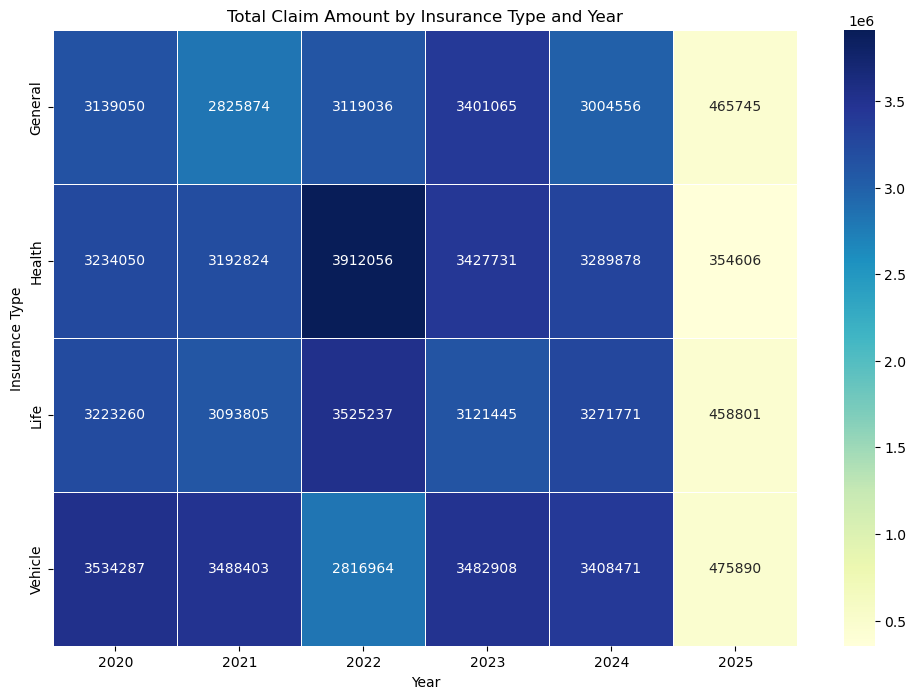

In [97]:
# Group by Insurance_Type and Year (Total Claim Amount)
amount_by_insurance_year = claim_data.groupby(['Insurance_Type', 'Year'])['Claim_Amount'].sum().reset_index()

print("\nSummary Statistics for Total Claim Amount by Insurance Type and Year:")
print("-" * 80)  # Adjusted table border width
print(f"{'Insurance Type':<20} {'Year':<10} {'Total Claim Amount':>20}")
print("-" * 80)

# Print each row
for _, row in amount_by_insurance_year.iterrows():
    print(f"{row['Insurance_Type']:<20} {row['Year']:<10} {row['Claim_Amount']:>20,.2f}")

print("-" * 80)

# Visualization: Heatmap
pivot_table = amount_by_insurance_year.pivot(index='Insurance_Type', columns='Year', values='Claim_Amount')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt='.0f', cmap='YlGnBu', linewidths=0.5)
plt.title('Total Claim Amount by Insurance Type and Year')
plt.ylabel('Insurance Type')
plt.xlabel('Year')
plt.show()

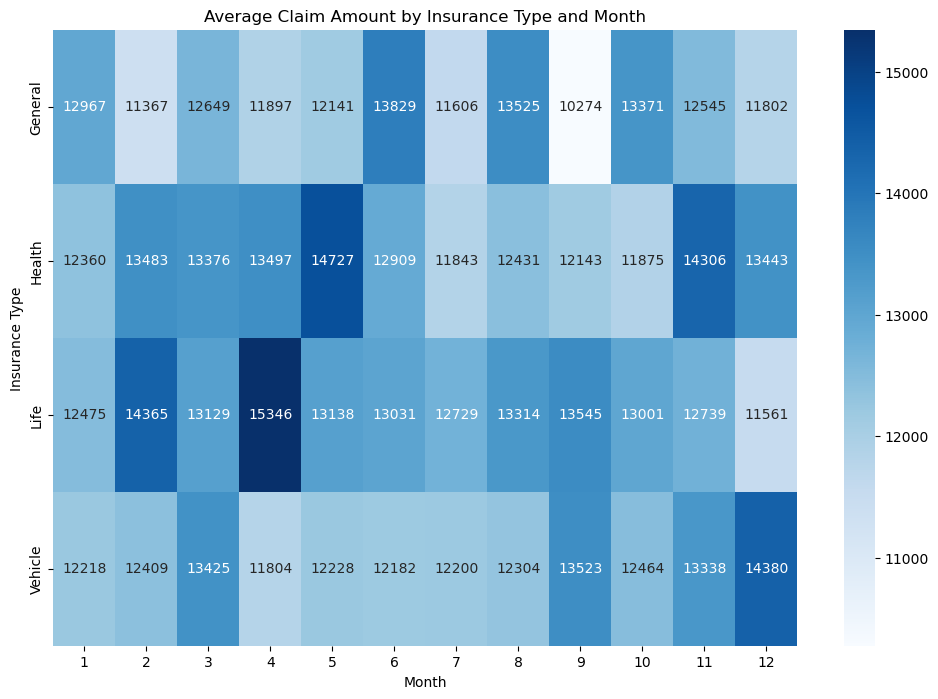

In [98]:
#  Group by Insurance_Type and Month (Average Claim Amount)
amount_by_insurance_month = claim_data.groupby(['Insurance_Type', 'Month'])['Claim_Amount'].mean().unstack()
#print("\nAverage Claim Amount by Insurance Type and Month:")
#print(amount_by_insurance_month)

# Visualize as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(amount_by_insurance_month, annot=True, fmt='.0f', cmap='Blues')
plt.title('Average Claim Amount by Insurance Type and Month')
plt.ylabel('Insurance Type')
plt.xlabel('Month')
plt.show()

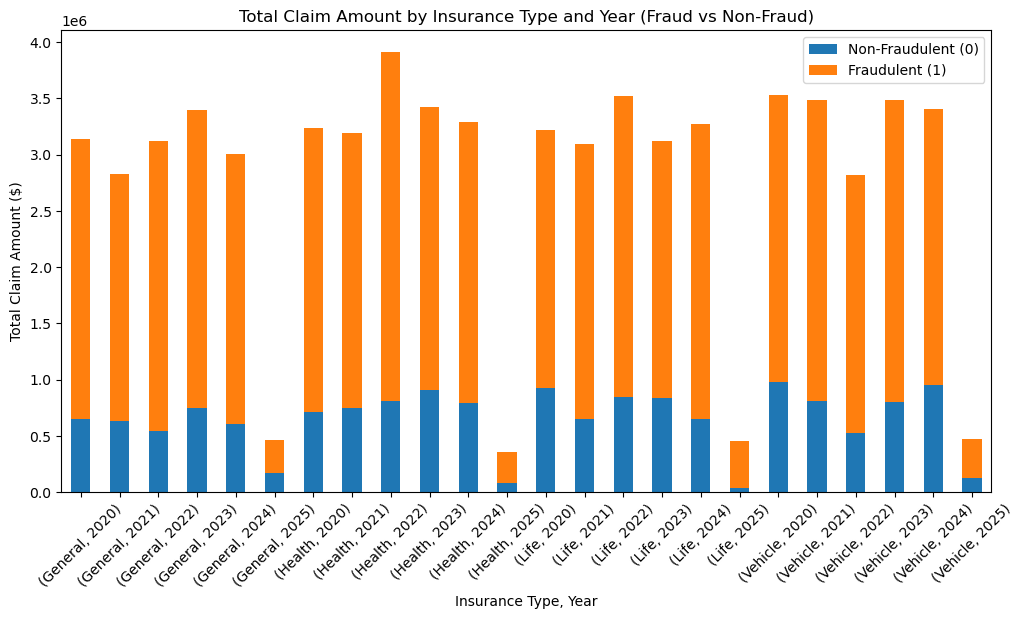

In [99]:
#  Group by Insurance_Type, Year, and Fraud_Flag (Total Claim Amount)

amount_by_insurance_year_fraud = claim_data.groupby(['Insurance_Type', 'Year', 'Fraud_Flag'])['Claim_Amount'].sum().unstack()
#print("\nTotal Claim Amount by Insurance Type, Year, and Fraud Flag:")
#print(amount_by_insurance_year_fraud)

# Visualize (stacked bar plot)
amount_by_insurance_year_fraud.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Total Claim Amount by Insurance Type and Year (Fraud vs Non-Fraud)')
plt.ylabel('Total Claim Amount ($)')
plt.xlabel('Insurance Type, Year')
plt.legend(['Non-Fraudulent (0)', 'Fraudulent (1)'])
plt.xticks(rotation=45)
plt.show()


Total Claim Amount by Insurance Type, Year, and Claim Status:
Claim_Status           Approved      Denied  Under Review
Insurance_Type Year                                      
General        2020   959061.58  1125345.57    1054643.21
               2021  1021067.55   966984.96     837821.27
               2022  1043323.42  1095448.57     980264.14
               2023  1050104.41  1313617.15    1037343.63
               2024  1006251.11   922737.67    1075567.52
               2025   144506.71   207614.74     113623.60
Health         2020  1071447.42  1224579.87     938022.47
               2021  1141571.04  1090311.00     960941.93
               2022  1199007.73  1412445.25    1300603.14
               2023  1023319.36   994811.65    1409600.01
               2024  1121849.70  1048224.71    1119803.38
               2025   100707.72   116110.78     137787.62
Life           2020  1145664.26  1178879.65     898715.85
               2021  1239381.41   957418.26     897005.55
         

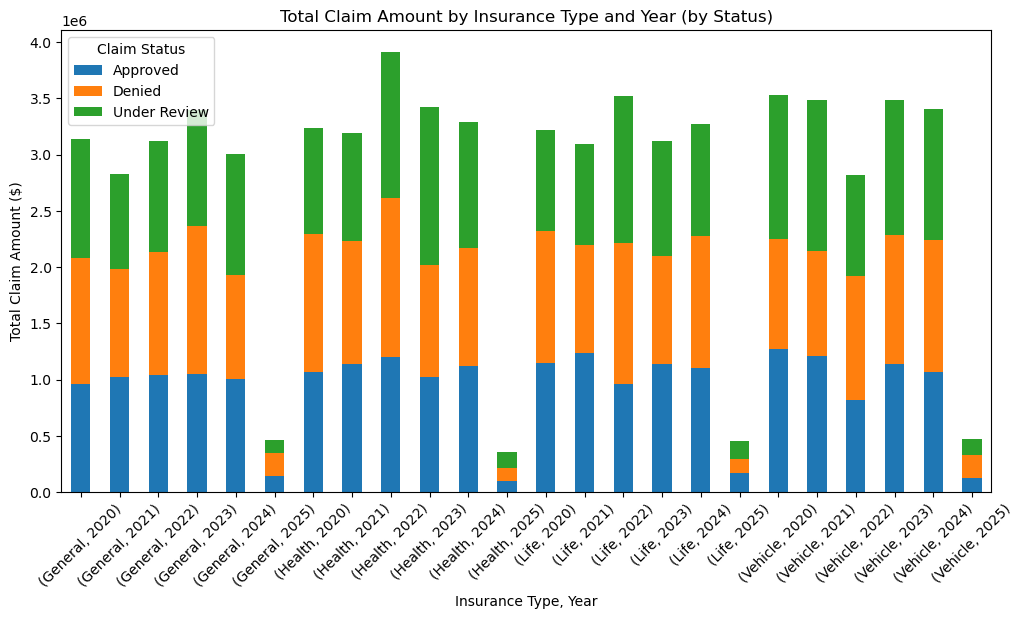

In [29]:
#  Group by Insurance_Type, Year, and Claim_Status (Total Claim Amount)

amount_by_insurance_year_status = claim_data.groupby(['Insurance_Type', 'Year', 'Claim_Status'])['Claim_Amount'].sum().unstack()
print("\nTotal Claim Amount by Insurance Type, Year, and Claim Status:")
print(amount_by_insurance_year_status)

# Visualize (stacked bar plot)
amount_by_insurance_year_status.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Total Claim Amount by Insurance Type and Year (by Status)')
plt.ylabel('Total Claim Amount ($)')
plt.xlabel('Insurance Type, Year')
plt.legend(title='Claim Status')
plt.xticks(rotation=45)
plt.show()


Total Claim Amount for Fraudulent Claims by Insurance Type, Year, and Fraud Category:
Fraud_Category       Exaggerated Loss  Intentional Damage  Staged Accident
Insurance_Type Year                                                       
General        2020         868526.39           862010.00        758239.50
               2021         623840.45           747810.20        824863.36
               2022        1111528.36           593601.67        866921.27
               2023         717906.36           995189.88        941255.22
               2024        1038635.74           780731.22        576658.73
               2025          77024.69           114681.57         99719.79
Health         2020         794068.90           884126.23        844241.81
               2021         812427.38           872795.49        756289.78
               2022        1001881.21          1043689.07       1060686.48
               2023         721335.50           901513.95        901146.69
             

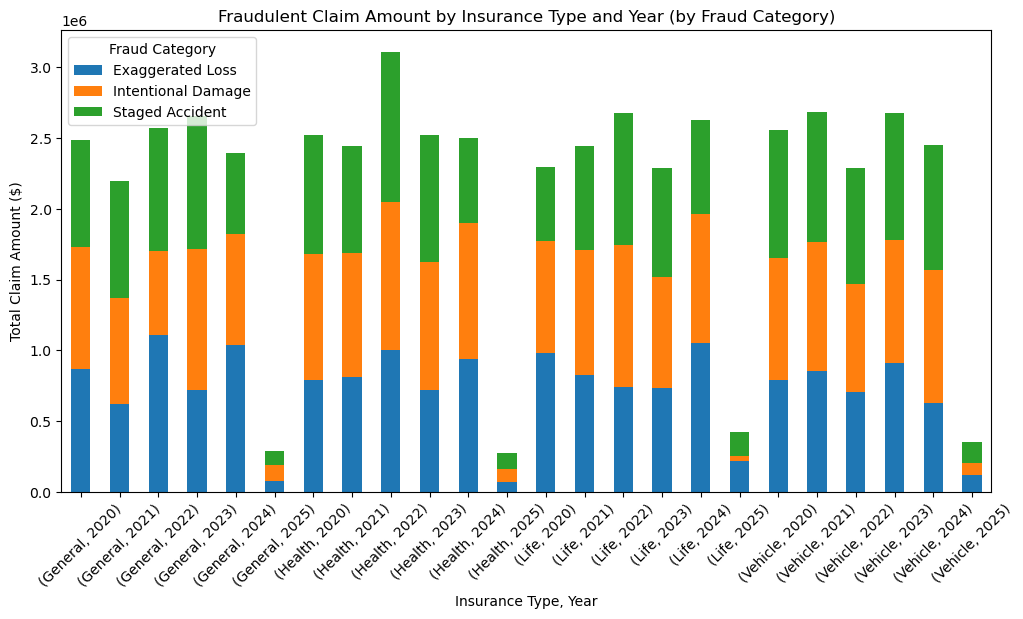

In [100]:
#  Group by Insurance_Type, Year, and Fraud_Category (Total Claim Amount for Fraudulent Claims)
claim_data_1 = claim_data[claim_data['Fraud_Flag'] == 1]
amount_by_insurance_year_fraudcat = claim_data_1.groupby(['Insurance_Type', 'Year', 'Fraud_Category'])['Claim_Amount'].sum().unstack()
print("\nTotal Claim Amount for Fraudulent Claims by Insurance Type, Year, and Fraud Category:")
print(amount_by_insurance_year_fraudcat)

# Visualize (stacked bar plot)
amount_by_insurance_year_fraudcat.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Fraudulent Claim Amount by Insurance Type and Year (by Fraud Category)')
plt.ylabel('Total Claim Amount ($)')
plt.xlabel('Insurance Type, Year')
plt.legend(title='Fraud Category')
plt.xticks(rotation=45)
plt.show()

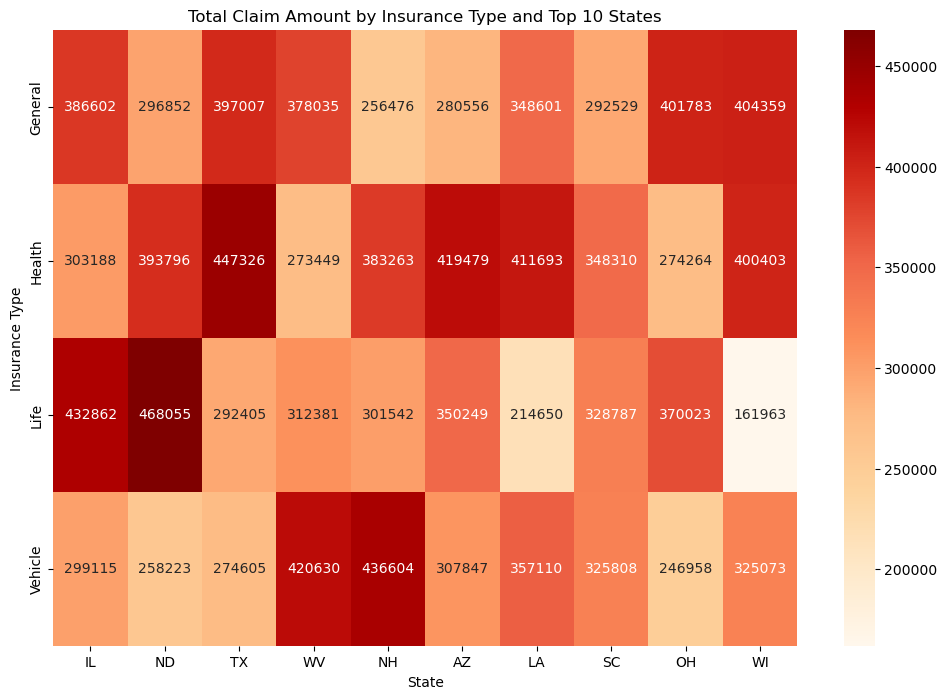

In [101]:
#  Group by Insurance_Type and State (Total Claim Amount)

amount_by_insurance_state = claim_data.groupby(['Insurance_Type', 'State'])['Claim_Amount'].sum().unstack().fillna(0)
#print("\nTotal Claim Amount by Insurance Type and State (Top 10 States):")
top_states = amount_by_insurance_state.sum().nlargest(10).index
#print(amount_by_insurance_state[top_states])

# Visualize as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(amount_by_insurance_state[top_states], annot=True, fmt='.0f', cmap='OrRd')
plt.title('Total Claim Amount by Insurance Type and Top 10 States')
plt.ylabel('Insurance Type')
plt.xlabel('State')
plt.show()

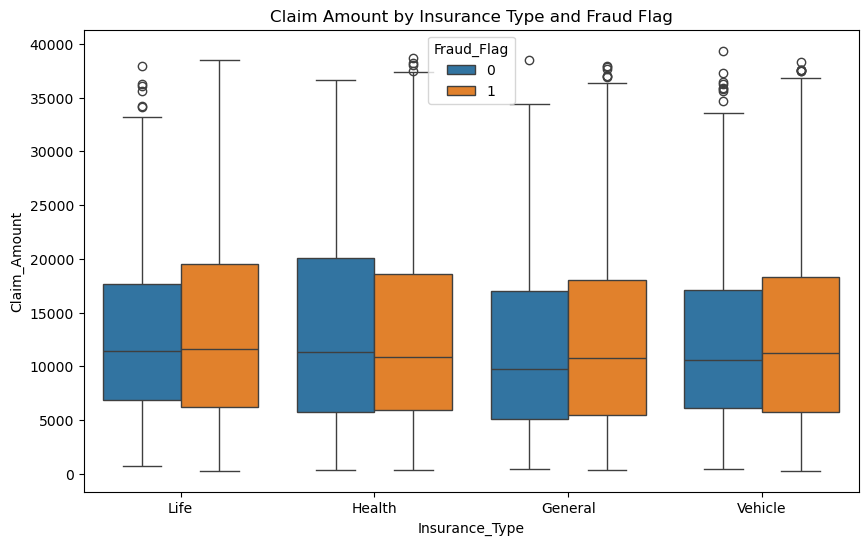

Top 10 States by Fraud Rate:
 State
MA    0.905405
MD    0.888889
MO    0.855556
CO    0.831683
VT    0.821053
NJ    0.816327
AK    0.811765
PA    0.802469
MT    0.802083
WI    0.800000
Name: Fraud_Flag, dtype: float64


In [102]:
# Boxplot by Insurance_Type to detect the outliers checking
plt.figure(figsize=(10, 6))
sns.boxplot(x='Insurance_Type', y='Claim_Amount', hue='Fraud_Flag', data=claim_data)
plt.title('Claim Amount by Insurance Type and Fraud Flag')
plt.show()

# Fraud rate by State
fraud_by_state = claim_data.groupby('State')['Fraud_Flag'].mean().sort_values(ascending=False).head(10)
print("Top 10 States by Fraud Rate:\n", fraud_by_state)

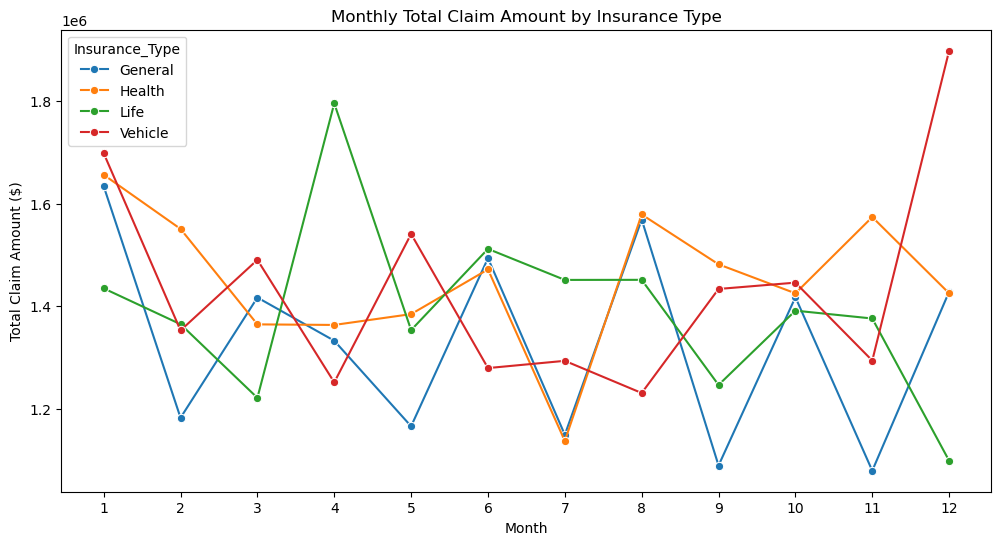

In [105]:
# Create monthly_trends by grouping by Insurance_Type and Month, summing Claim_Amount
monthly_trends = claim_data.groupby(['Insurance_Type', 'Month'])['Claim_Amount'].sum().reset_index()

# Rename the summed column to 'sum' for clarity in the plot
monthly_trends = monthly_trends.rename(columns={'Claim_Amount': 'sum'})

# Line plot with data points for all Insurance_Types
plt.figure(figsize=(12, 6))
sns.lineplot(x='Month', y='sum', hue='Insurance_Type', data=monthly_trends, marker='o')
plt.title('Monthly Total Claim Amount by Insurance Type')
plt.ylabel('Total Claim Amount ($)')
plt.xlabel('Month')
plt.xticks(range(1, 13))  # Months 1 to 12
plt.show()



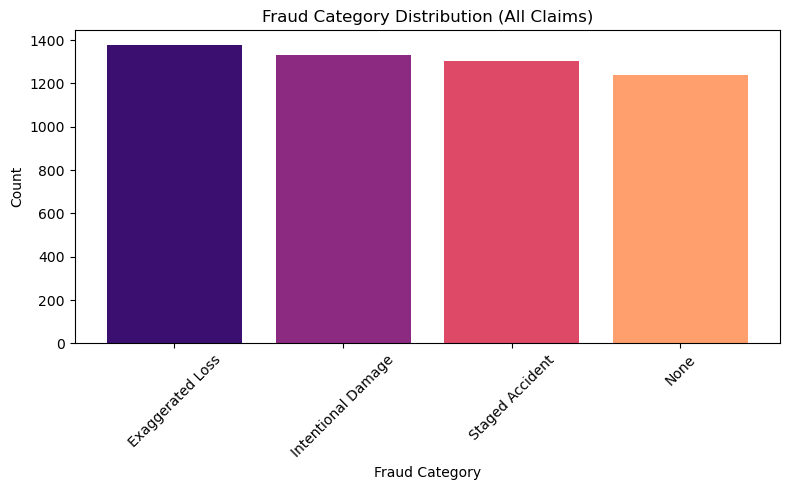


Fraud Category Counts (All Claims):
 Fraud_Category
Exaggerated Loss      1376
Intentional Damage    1332
Staged Accident       1305
None                  1237
Name: count, dtype: int64


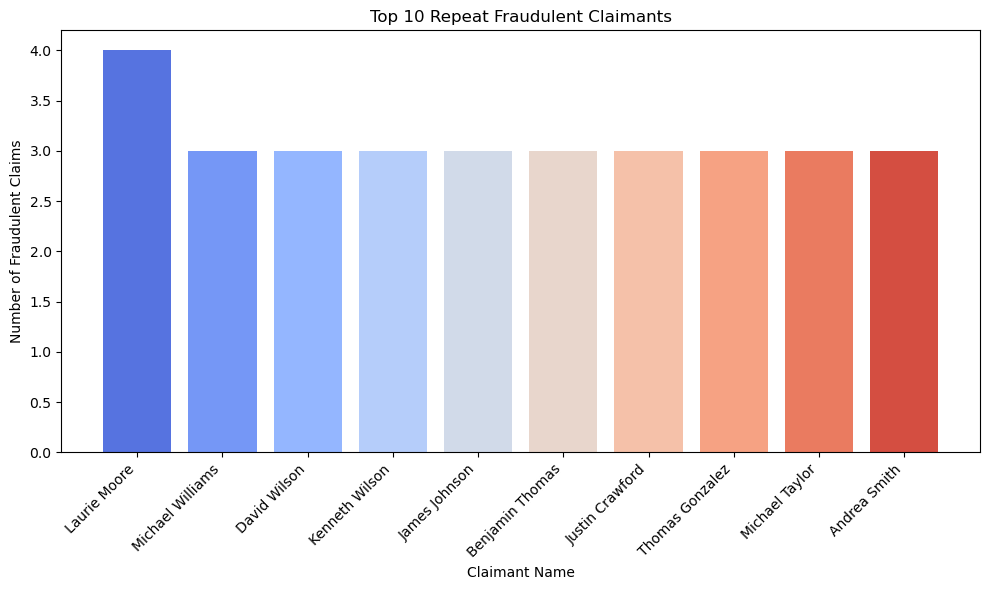


Top 10 Repeat Fraudulent Claimants:
 Claimant_Name
Laurie Moore        4
Michael Williams    3
David Wilson        3
Kenneth Wilson      3
James Johnson       3
Benjamin Thomas     3
Justin Crawford     3
Thomas Gonzalez     3
Michael Taylor      3
Andrea Smith        3
Name: count, dtype: int64


In [107]:
# Fraud Category breakdown for all claims (to show "None")
all_fraud_counts = claim_data['Fraud_Category'].value_counts()

# Plot the distribution for all claims
plt.figure(figsize=(8, 5))
plt.bar(all_fraud_counts.index, all_fraud_counts.values, color=sns.color_palette("magma", len(all_fraud_counts)))
plt.title('Fraud Category Distribution (All Claims)')
plt.xlabel('Fraud Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the counts for all claims
print("\nFraud Category Counts (All Claims):\n", all_fraud_counts)

# Repeat claimants (Top 10 fraudulent claimants)
repeat_fraud = claim_data[claim_data['Fraud_Flag'] == 1]['Claimant_Name'].value_counts().head(10)

# Plot the top 10 repeat fraudulent claimants
plt.figure(figsize=(10, 6))
plt.bar(repeat_fraud.index, repeat_fraud.values, color=sns.color_palette("coolwarm", len(repeat_fraud)))
plt.title('Top 10 Repeat Fraudulent Claimants')
plt.xlabel('Claimant Name')
plt.ylabel('Number of Fraudulent Claims')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print the top 10 repeat fraudulent claimants
print("\nTop 10 Repeat Fraudulent Claimants:\n", repeat_fraud)

T-test: Fraud vs Non-Fraud Claim Amounts
Statistic: 1.16, P-value: 0.2458
Mean Fraudulent: $12889.88, Mean Non-Fraudulent: $12563.15
Variance Fraudulent: 76080842.19, Variance Non-Fraudulent: 71189515.67

Interpretation:
- P-value > 0.05: Fail to reject null hypothesis.
- No significant evidence that fraudulent claims are larger than non-fraudulent claims.
- Note: High variance and skewness may dilute significance; consider Welch’s t-test or non-parametric tests.


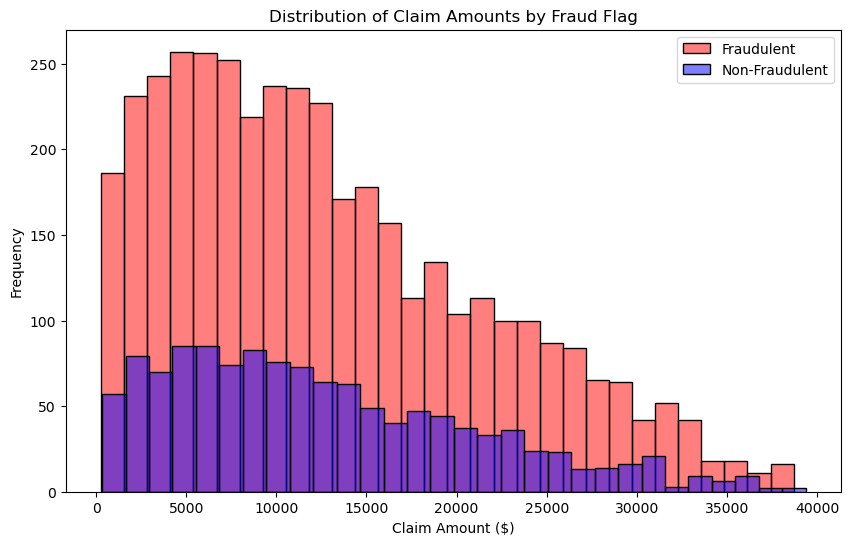

In [109]:
# Statistical Testing: Are fraudulent claims larger?
fraud_amounts = claim_data[claim_data['Fraud_Flag'] == 1]['Claim_Amount']
non_fraud_amounts = claim_data[claim_data['Fraud_Flag'] == 0]['Claim_Amount']
t_stat, p_value = ttest_ind(fraud_amounts, non_fraud_amounts)

print(f"T-test: Fraud vs Non-Fraud Claim Amounts")
print(f"Statistic: {t_stat:.2f}, P-value: {p_value:.4f}")
print(f"Mean Fraudulent: ${fraud_amounts.mean():.2f}, Mean Non-Fraudulent: ${non_fraud_amounts.mean():.2f}")
print(f"Variance Fraudulent: {fraud_amounts.var():.2f}, Variance Non-Fraudulent: {non_fraud_amounts.var():.2f}")
print("\nInterpretation:")
print("- P-value > 0.05: Fail to reject null hypothesis.")
print("- No significant evidence that fraudulent claims are larger than non-fraudulent claims.")
print("- Note: High variance and skewness may dilute significance; consider Welch’s t-test or non-parametric tests.")

# Visualization
plt.figure(figsize=(10, 6))
sns.histplot(fraud_amounts, color='red', label='Fraudulent', bins=30, alpha=0.5)
sns.histplot(non_fraud_amounts, color='blue', label='Non-Fraudulent', bins=30, alpha=0.5)
plt.title('Distribution of Claim Amounts by Fraud Flag')
plt.xlabel('Claim Amount ($)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [37]:
#Predictive Modeling (basic)
#A simple fraud prediction model

X = pd.get_dummies(claim_data[['Claim_Amount', 'Insurance_Type', 'Claim_Status', 'State']], drop_first=True)
y = claim_data['Fraud_Flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7015873015873015
